
# EDA and Data Cleaning

<p>Specifically targeted flights to three countries:
    <ol>
        <li>Singapore</li>
        <li>South Korea</li>
        <li>Thailand</li>
    </ol>
From the following locations in the United States:
    <ol>
        <li>New Jersey</li>
        <li>New York</li>
        <li>California</li>
    </ol>
This was done to reduce complexity and size of the data needed for this project</p>

In [1]:
import pandas as pd
import numpy as np
import zipfile

In [2]:
def zip_to_df(zip_path):
    zf = zipfile.ZipFile(zip_path, mode='r')
    mdf = pd.DataFrame()
    
    #Iterate through files in zip file
    for zipfilename in zf.namelist():

        #Read contents of the file and append to mdf
        df = pd.read_csv(zf.open(zipfilename))
        df['departure_date'] = zipfilename[-28:-18]

        mdf = mdf.append(df)
    #close zip file
    zf.close()
    
    return mdf

def df_dict_compiler():
    zip_path_list = ['data/EWR_to_SIN.zip', 'data/NYC_to_SIN.zip', 'data/NYC_to_ICN.zip']
    df_dict = {}
    
    for path in zip_path_list:
        df = zip_to_df(path)
        df = df_cleaner(df)
        df_dict[path[5:15]] = df
    
    return df_dict

def df_compiler():
    df_dict = df_dict_compiler()
    mdf = pd.DataFrame()
    
    for df in df_dict.values():
        mdf = mdf.append(df)
    
    mdf.drop_duplicates(inplace=True)
    return mdf


# ADD SEARCHED DATE (Day of the Week) AND TIME?


In [3]:
def target_assigner(df):
    min_price = df['Price'].min()
    
    mid_price = df['Price'].describe()['50%']
    mid_duration = df['total_duration'].describe()['50%']

    df['target'] = np.where( ( (df['Price'] < mid_price) & (df['total_duration'] < mid_duration) ), 1, 0)
    
    return df

def total_duration(df):
    out_total = []
    ret_total = []
    
    for dur in df['Out Duration']:
        hr = int(dur.split('h')[0]) * 60
        m = int(dur.split('h')[1][:-1])
        total = hr + m
        out_total.append(total)

    for dur in df['Return Duration']:
        hr = int(dur.split('h')[0]) * 60
        m = int(dur.split('h')[1][:-1])
        total = hr + m
        ret_total.append(total)
        
    df['total_duration'] = pd.Series(out_total) + pd.Series(ret_total)
    
    return df

def dep_ret_time(df):
    dep_times = []
    ret_times = []
    
    for time in df['Out Time']:
        dep_times.append(time.split(' ')[0])
    
    for time in df['Return Time']:
        ret_times.append(time.split(' ')[0])
    
    df['dep_time'] = pd.Series(dep_times)
    df['ret_time'] = pd.Series(ret_times)
    
    return df

def dep_ret_airline(df):

    dep_air = [airline.split(',')[0] for airline in df['Out Airline']]
    ret_air = [airline.split(',')[0] for airline in df['Return Airline']]
    
    df['dep_airline'] = pd.Series(dep_air)
    df['ret_airline'] = pd.Series(ret_air)
    
    return df

def df_cleaner(df):
    df_duration = total_duration(df)
    
    df_times = dep_ret_time(df_duration)
    
    df_airlines = dep_ret_airline(df_times)
    
    df_airlines['total_stops'] = df['Out Stops'] + df['Return Stops']
    
    dfc = target_assigner(df_airlines)
    
    return dfc

In [4]:
df = df_compiler()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11092 entries, 0 to 45
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Out Time            11092 non-null  object
 1   Out Airline         11092 non-null  object
 2   Out Cities          11092 non-null  object
 3   Out Duration        11092 non-null  object
 4   Out Stops           11092 non-null  int64 
 5   Out Stop Cities     8029 non-null   object
 6   Return Time         11092 non-null  object
 7   Return Airline      11092 non-null  object
 8   Return Cities       11092 non-null  object
 9   Return Duration     11092 non-null  object
 10  Return Stops        11092 non-null  int64 
 11  Return Stop Cities  8139 non-null   object
 12  Price               11092 non-null  int64 
 13  timestamp           11092 non-null  object
 14  sort                11092 non-null  object
 15  departure_date      11092 non-null  object
 16  total_duration      11092

In [5]:
df['target'].value_counts(normalize=True)

0    0.890732
1    0.109268
Name: target, dtype: float64

In [6]:
df.head()

,Out Time,Out Airline,Out Cities,Out Duration,Out Stops,Out Stop Cities,Return Time,Return Airline,Return Cities,Return Duration,...,timestamp,sort,departure_date,total_duration,dep_time,ret_time,dep_airline,ret_airline,total_stops,target
0,8:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,27h40m,2,"ATL, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,...,20220403-1414,cheap,2022-04-10,3245,8:00,1:10,Korean Air,Korean Air,4,0
1,9:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,26h40m,2,"BOS, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,...,20220403-1414,cheap,2022-04-10,3185,9:00,1:10,Korean Air,Korean Air,4,0
2,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,...,20220403-1414,cheap,2022-04-10,2860,11:25,6:10,ANA,ANA,2,1
3,6:30 am – 12:35 am +2,ANA,EWR‐SIN,30h05m,2,"LAX, NRT",6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,...,20220403-1414,cheap,2022-04-10,3155,6:30,6:10,ANA,ANA,3,0
4,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,10:10 pm – 9:27 pm +1,ANA,SIN‐EWR,35h17m,...,20220403-1414,cheap,2022-04-10,3627,11:25,10:10,ANA,ANA,3,0


In [7]:
# Iterate over all column names of Dataframe
for col in df.columns:
    # Select the column by name and get count of unique values in it
    count = df[col].nunique()
    print(f'Count of Unique values in Column {col} is: {count}')

Count of Unique values in Column Out Time is: 458
Count of Unique values in Column Out Airline is: 63
Count of Unique values in Column Out Cities is: 6
Count of Unique values in Column Out Duration is: 288
Count of Unique values in Column Out Stops is: 4
Count of Unique values in Column Out Stop Cities is: 113
Count of Unique values in Column Return Time is: 613
Count of Unique values in Column Return Airline is: 64
Count of Unique values in Column Return Cities is: 7
Count of Unique values in Column Return Duration is: 459
Count of Unique values in Column Return Stops is: 4
Count of Unique values in Column Return Stop Cities is: 123
Count of Unique values in Column Price is: 1908
Count of Unique values in Column timestamp is: 723
Count of Unique values in Column sort is: 3
Count of Unique values in Column departure_date is: 87
Count of Unique values in Column total_duration is: 96
Count of Unique values in Column dep_time is: 36
Count of Unique values in Column ret_time is: 21
Count o

In [8]:
# for dur in tdf['Out Duration']:
#     hr = int(dur.split('h')[0]) * 60
#     m = int(dur.split('h')[1][:-1])
#     total = hr + m
    
#     formated = str(f'{total//60}h{total%60}m')
#     print(total, formated)

In [9]:
# zf.namelist()[0][-28:-18]
# zf.namelist()[0][-23:-18]

---

In [10]:
time_df = df.set_index(pd.to_datetime(df['departure_date']), drop=True)

time_df = time_df['Price']
time_df

departure_date
2022-04-10     951
2022-04-10     979
2022-04-10     994
2022-04-10     994
2022-04-10     998
              ... 
2022-07-05    1971
2022-07-05    1985
2022-07-05    2457
2022-07-05    2964
2022-07-05    2159
Name: Price, Length: 11092, dtype: int64

In [11]:
import matplotlib.pyplot as plt
import matplotlib

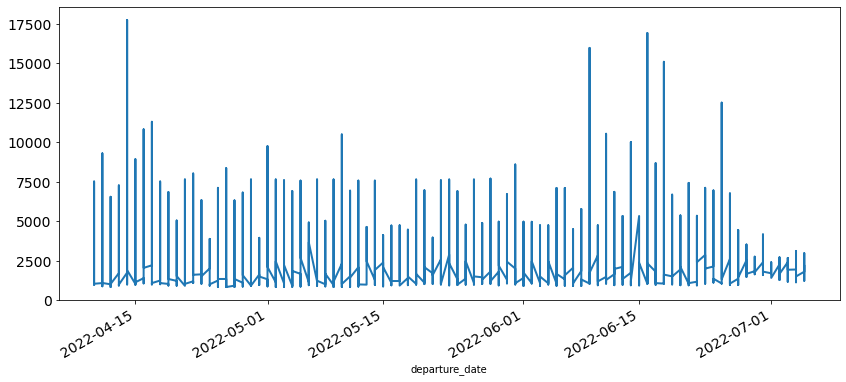

In [12]:
time_df.plot(figsize=(14,6), linewidth=2, fontsize=14);

In [13]:
# importing relevant library
from statsmodels.tsa.stattools import adfuller

# For testing stationarity
def dicky_fuller_test(data):
    alpha = 0.05
    is_stationary = adfuller(data)[1] < alpha
    if is_stationary == True:
        print(f'The data is stationary with a fuller score of {round(adfuller(data)[1],3)}')
    else:
        print(f'The data is not stationary with a fuller score of {round(adfuller(data)[1],3)}')
    return

In [14]:
dicky_fuller_test(time_df)

The data is stationary with a fuller score of 0.0


In [15]:
# df.to_csv('data/masterdf.csv', index=False) 

In [16]:
df = pd.read_csv('data/masterdf.csv')
df.head()

,Out Time,Out Airline,Out Cities,Out Duration,Out Stops,Out Stop Cities,Return Time,Return Airline,Return Cities,Return Duration,...,timestamp,sort,departure_date,total_duration,dep_time,ret_time,dep_airline,ret_airline,total_stops,target
0,8:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,27h40m,2,"ATL, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,...,20220403-1414,cheap,2022-04-10,3245,8:00,1:10,Korean Air,Korean Air,4,0
1,9:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,26h40m,2,"BOS, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,...,20220403-1414,cheap,2022-04-10,3185,9:00,1:10,Korean Air,Korean Air,4,0
2,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,...,20220403-1414,cheap,2022-04-10,2860,11:25,6:10,ANA,ANA,2,1
3,6:30 am – 12:35 am +2,ANA,EWR‐SIN,30h05m,2,"LAX, NRT",6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,...,20220403-1414,cheap,2022-04-10,3155,6:30,6:10,ANA,ANA,3,0
4,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,10:10 pm – 9:27 pm +1,ANA,SIN‐EWR,35h17m,...,20220403-1414,cheap,2022-04-10,3627,11:25,10:10,ANA,ANA,3,0
